In [6]:
# forecast_df


In [9]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sqlalchemy import create_engine
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # Database connection parameters
# db_config = {
#     'user': 'root',
#     'password': 'root',
#     'host': 'localhost',
#     'port': '3306',  # default MySQL port is 3306
#     'database': 'cdac_project'
# }

# # Create a SQLAlchemy engine using PyMySQL
# engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# # Fetch data for the specified ticker
# ticker = 'INFY.NS'
# query = f"SELECT Date_time, Close FROM nifty_data_002 WHERE Ticker = '{ticker}' ORDER BY Date_time"
# data = pd.read_sql(query, engine)

# # Convert Date_time to datetime and set it as index
# data['Date_time'] = pd.to_datetime(data['Date_time'])
# data.set_index('Date_time', inplace=True)

# # Normalize the 'Close' prices
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# # Create sequences for LSTM
# def create_dataset(data, time_step=1):
#     X, y = [], []
#     for i in range(len(data) - time_step - 1):
#         X.append(data[i:(i + time_step), 0])
#         y.append(data[i + time_step, 0])
#     return np.array(X), np.array(y)

# # Set the time step
# time_step = 60  # 60 days of historical data
# X, y = create_dataset(scaled_data, time_step)

# # Reshape X to be [samples, time steps, features]
# X = X.reshape(X.shape[0], X.shape[1], 1)

# # Split into training and testing sets
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Implement EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with EarlyStopping
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Forecast the next 30 days
# last_data = scaled_data[-time_step:]
# forecast = []
# for _ in range(30):
#     next_day = model.predict(last_data[np.newaxis, :, :])
#     forecast.append(next_day[0, 0])
#     last_data = np.concatenate([last_data[1:], [[next_day[0, 0]]]], axis=0)

# # Inverse transform the forecast
# forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# # Create a DataFrame with forecasted prices and ticker name
# forecast_df = pd.DataFrame({
#     'Date': pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30),
#     'Forecasted_Price': forecast.flatten(),
#     'Ticker': ticker
# })

In [10]:
# forecast_df

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Database connection parameters
db_config = {
    'user': 'root',
    'password': 'root',
    'host': 'localhost',
    'port': '3306',  # default MySQL port is 3306
    'database': 'cdac_project'
}

# Create a SQLAlchemy engine using PyMySQL
engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# Fetch data for the specified ticker
ticker = 'INFY.NS'
query = f"SELECT Date_time, Close FROM nifty_data_002 WHERE Ticker = '{ticker}' ORDER BY Date_time"
data = pd.read_sql(query, engine)

# Convert Date_time to datetime and set it as index
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.set_index('Date_time', inplace=True)

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set the time step
time_step = 60  # 60 days of historical data
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate evaluation metrics
mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)
rmse = np.sqrt(mse)
r2 = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)

# Forecast the next 30 days
last_data = scaled_data[-time_step:]
forecast = []
for _ in range(30):
    next_day = model.predict(last_data[np.newaxis, :, :])
    forecast.append(next_day[0, 0])
    last_data = np.concatenate([last_data[1:], [[next_day[0, 0]]]], axis=0)

# Inverse transform the forecast
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create a DataFrame with forecasted prices and ticker name
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30),
    'Forecasted_Price': forecast.flatten(),
    'Ticker': ticker
})

Epoch 1/100
9/9 [==============================] - 9s 288ms/step - loss: 0.0397 - val_loss: 0.0134
Epoch 2/100
9/9 [==============================] - 1s 82ms/step - loss: 0.0106 - val_loss: 0.0254
Epoch 3/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 4/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 5/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 6/100
9/9 [==============================] - 1s 84ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 8/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 10/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 11/100
9/9 

In [2]:
forecast_df

,Date,Forecasted_Price,Ticker
0,2024-08-14,1785.422363,INFY.NS
1,2024-08-15,1790.462891,INFY.NS
2,2024-08-16,1791.269775,INFY.NS
3,2024-08-17,1790.188477,INFY.NS
4,2024-08-18,1787.875854,INFY.NS
5,2024-08-19,1784.604858,INFY.NS
6,2024-08-20,1780.566650,INFY.NS
7,2024-08-21,1775.937378,INFY.NS
8,2024-08-22,1770.884033,INFY.NS
9,2024-08-23,1765.560425,INFY.NS


In [3]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R2 Score: {r2:.2f}')

Mean Absolute Error: 21.77
Mean Squared Error: 826.58
Root Mean Squared Error: 28.75
R2 Score: 0.96


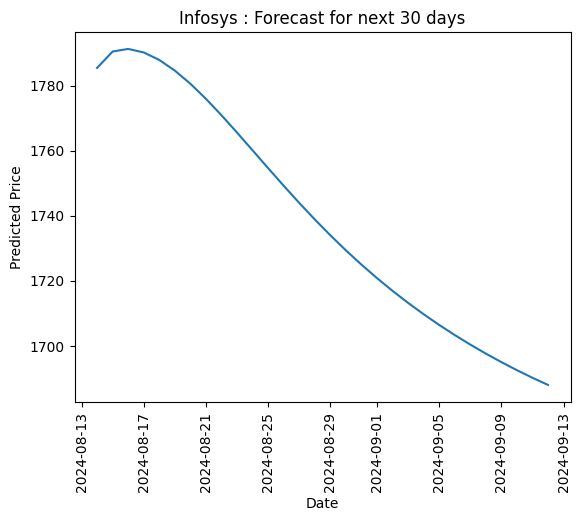

In [6]:
import matplotlib.pyplot as plt

plt.plot(forecast_df['Date'],forecast_df['Forecasted_Price'])
plt.title('Infosys : Forecast for next 30 days')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.xticks(rotation='vertical')
plt.show()

In [7]:
model.save("my_lstm_model.h5", save_format="h5")

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
